<a href="https://colab.research.google.com/github/pc-piyush/CAI5724/blob/master/CAI5724_PC_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digital Twin Framework for CDC Diabetes Database**

Digital Twin (DT) is an in-silico representation of a patient that enables dynamic simulation and prediction of health trajectory. They are built with an input of multi-modal, continuous, time-series factors from patient’s clinical, genetic and molecular data, frequently supplemented by environmental and social determinants to provide a holistic view of patient health.

The model is continuously updated with any new measurement and it updates the twin's internal state. The DT can then be posed 'what-if' cases and model runs simulations to predict outcomes and health trajectory.

In training, the predicted outcomes are compared to clinical outcomes- to calibrate and validate the Digital Twin.

## **Problem Statement**

To develop a Digital Twin framework for CDC Diabetes Database to-

1. Predict future outcomes with simulating interventions on patient-level
2. Develop a Digital Twin view by finding similar patients- simulating intervention on them and observing model's predicted diabetes risk changes

Link to the Repo: https://github.com/pc-piyush/CAI5724

## **Step - 1 Installing and loading the packages**

The current framework requires the following packages-

- Loading dataset
### ucimlrepo [https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators]

- Data pre-processing
### Pandas , Numpy

- Data visualization
### matplotlib, seaborn

- Machine learning tasks
### scikit-learn, xgboost, lightgbm

- If needed, an interactive web-application to play in GUI mode
### streamlit

In [1]:
# !pip3 install -r requirements.txt
!pip3 install streamlit pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.2 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")

## **Step - 2 Framework specific python functions**

I like to create functions and templates to use later in the code, in case they need to be re-used.
Please hover over the function for more information

In [ ]:
def load_default_data():
    '''
    The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes.
    The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient.
    The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy.
    https://doi.org/10.24432/C53919

    '''
    try:
        repo = fetch_ucirepo(id=891)
        df = repo.data.features.copy()
        df['Diabetes_binary'] = repo.data.targets
        return df
    except Exception: #Default to csv file if the link does't work
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
        return pd.read_csv(url)

def build_preprocessor(X):
    '''
    Performs dataframe inspection and separating numeric and categorical variables;
    Implements a column transformer - scales numeric features so they have mean = 0 and standard deviation = 1 (StandardScaler) and
    converts categorical variables into binary indicator columns (OneHotEncoder)
    '''
    num_cols = ['BMI','MentHlth','PhysHlth','Age']#X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    preproc = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="drop")
    preproc.fit(X)
    # create feature names
    cat_feature_names = []
    if len(cat_cols) > 0:
        try:
            cat_feature_names = preproc.named_transformers_['cat'].get_feature_names_out(cat_cols)
        except Exception:
            cat_feature_names = preproc.named_transformers_['cat'].get_feature_names(cat_cols)
    feature_names = np.concatenate([num_cols, cat_feature_names])
    return preproc, feature_names, num_cols, cat_cols

def train_pipelines(X_train, y_train, preproc, random_state=42):
    '''
    Build pipelines by calling pre-processor function, fits training data and returns trained pipelines
    '''

    pipelines = {
        "RandomForest": Pipeline([("preproc", preproc), ("clf", RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1))]),
        "LogisticRegression": Pipeline([("preproc", preproc), ("clf", LogisticRegression(max_iter=1000, random_state=random_state))]),
        "XGBoost": Pipeline([("preproc", preproc), ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=random_state, n_jobs=-1))]),
        "LightGBM": Pipeline([("preproc", preproc), ("clf", LGBMClassifier(random_state=random_state, n_jobs=-1))]),
        "MLP": Pipeline([("preproc", preproc), ("clf", MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=random_state))])
    }
    trained = {}
    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        trained[name] = pipe
    return trained

def evaluate_pipelines(trained_pipes, X_test, y_test):
    '''
    runs every trained pipeline on the test set, gathers predictions, probability scores (when available),
    and computes classification metrics (precision, recall, F1, AUROC, AUPRC). It returns a tidy DataFrame of metrics and a dict of raw probabilities
    '''
    metrics = {}
    prob_dict = {}
    for name, pipe in trained_pipes.items():
        y_pred = pipe.predict(X_test)
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:,1]
        else:
            y_proba = pipe.predict(X_test)
        prob_dict[name] = y_proba
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precision = rep["1"]["precision"]
        recall = rep["1"]["recall"]
        f1 = rep["1"]["f1-score"]
        auroc = roc_auc_score(y_test, y_proba)
        auprc = average_precision_score(y_test, y_proba)
        metrics[name] = {"Precision": precision, "Recall": recall, "F1": f1, "AUROC": auroc, "AUPRC": auprc}
    return pd.DataFrame(metrics).T, prob_dict

def feature_importances_from_rf(rf_pipe, feature_names):
    '''
    Extracts feature importance from Random Forest classifier for feature selection
    '''
    rf = rf_pipe.named_steps['clf']
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    fi_df["cum_importance"] = fi_df["importance"].cumsum()
    return fi_df

def retrain_on_selected(X_train_trans, X_test_trans, selected_indices, y_train, y_test, models_dict, random_state=42):
    '''
    After feature selection, retrain the models on selected features and extracts the performance metrics again
    '''
    X_train_sel = X_train_trans[:, selected_indices]
    X_test_sel = X_test_trans[:, selected_indices]
    reduced_trained = {}
    reduced_metrics = {}
    for name, est in models_dict.items():
        EstClass = est.__class__
        params = est.get_params()
        try:
            new_est = EstClass(**params)
        except Exception:
            new_est = EstClass()
        new_est.fit(X_train_sel, y_train)
        reduced_trained[name] = new_est
        # predict
        if hasattr(new_est, "predict_proba"):
            y_proba = new_est.predict_proba(X_test_sel)[:,1]
            y_pred = new_est.predict(X_test_sel)
        else:
            y_proba = new_est.predict(X_test_sel)
            y_pred = new_est.predict(X_test_sel)
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precision = rep["1"]["precision"]; recall = rep["1"]["recall"]; f1 = rep["1"]["f1-score"]
        auroc = roc_auc_score(y_test, y_proba); auprc = average_precision_score(y_test, y_proba)
        reduced_metrics[name] = {"Precision": precision, "Recall": recall, "F1": f1, "AUROC": auroc, "AUPRC": auprc}
    return reduced_trained, pd.DataFrame(reduced_metrics).T

def get_similar_indices(X_sim_space, patient_idx, metric="euclidean", top_k=5):
    '''
    computes pair-wise distance and similarities across the whole dataset for a patient index and different similarity metrics
    '''
    if metric == "euclidean":
        dists = euclidean_distances(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        maxd = dists.max() if dists.max() > 0 else 1.0
        sims = (1 - (dists / maxd)) * 100
    elif metric == "cosine":
        sims_raw = cosine_similarity(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        sims = ((sims_raw - sims_raw.min()) / (sims_raw.max() - sims_raw.min() + 1e-12)) * 100
    elif metric == "manhattan":
        dists = manhattan_distances(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        maxd = dists.max() if dists.max() > 0 else 1.0
        sims = (1 - (dists / maxd)) * 100
    else:
        raise ValueError("Unknown metric")
    sims[patient_idx] = -np.inf
    top_idx = np.argsort(-sims)[:top_k]
    top_sims = sims[top_idx]
    return top_idx, top_sims

def apply_intervention(series, bmi_delta=-3.0, set_phys_active=True):
    '''
    Implements demo interventions- BMI change and Physical activity to observe changes in predicted probabilites of the target variables
    '''
    s = series.copy()
    if "BMI" in s.index:
        try:
            s["BMI"] = float(s["BMI"]) + float(bmi_delta)
        except Exception:
            pass
    if set_phys_active and "PhysActivity" in s.index:
        s["PhysActivity"] = 1
    return s

## **Step - 3 Default parameters**

In [ ]:
patient_idx = 0 #Test patient for Digital Twin simulation and similarity matching

sim_metric = 'cosine' #Preferred distance matrix- options are euclidean, cosine and manhattan

top_k = 5 #Number of similar patients the model is requiring to retrieve

bmi_delta = -3 # Intervention

set_phys_active = 1 #Intervention

run_similarity = True

PLOT_TOP_N = top_k #Plotting equal number of similar patients as identified above

fi_threshold = 0.02 #Filters out features from RF model with importance above this threshold


## **Step - 4 Data Preview**

- I always print head() for any dataframe to have a brief look at the variables and their data types
- As we see below, categorical variables with binary values are defaults to int, hence we will need to either import them with specific datatype values or account for it when creating a classification for our numeric and categorical features

In [ ]:
df = load_default_data()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None) # Display full content of cells
print("### Dataset preview")

print('Datatypes as retrieved by py')
print(df.dtypes)

print('Preview dataset')
print(df.head(5))

print("Shape:", df.shape)
print("Class balance (Diabetes_binary):")
print(df["Diabetes_binary"].value_counts(normalize=True).rename("proportion"))

### Dataset preview
Datatypes as retrieved by py
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Diabetes_binary         int64
dtype: object
Preview dataset
   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1


- We will inspect our dataframe now and split the features and outcome variable (in this case Diabetes_binary)
- The feature matrix, *X* will be run through the pre-processor function defined earlier
        - Split the feature matrix in numeric and categorical features
        - Builds a ColumnTransformer that transforms Numerical features with StandardScaler (distribution with mean=0 and StdDev = 1) and Categorical features with OneHotEncoder (each categorical value will create a binary variable with 0 and 1 assignments)
        - The output returns a pre-processed dataframe with feature names and split into numerical and categorical features
        - Splits the data in training and testing dataset (70:30 ratio)

In [ ]:
X = df.drop(columns=["Diabetes_binary"]).copy()
y = df["Diabetes_binary"].copy().astype(int)

preproc, feature_names, num_cols, cat_cols = build_preprocessor(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train_trans = preproc.transform(X_train)
X_test_trans = preproc.transform(X_test)

mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train_trans)
X_test_mm = mm.transform(X_test_trans)



## **Step - 5.2 Model fitting**

We will try to create a *model zoo* - a group of different models to be trained and compared for our dataset. We will use the models below-

1. Random Forest - Builds decision trees for the dataset and averges the predictions
2. Logistic Regression - predicts probabilites by fitting a straight-line decision boundary and passing the results to a sigmoid curve
3. XGBoost - gradient boosting model that builds trees one-by-one, each correcting errors of the previous tree - known for high accuracy
4. LGBM - gradient boosting model, optimized for speed, especially on large datasets. Uses histogram-based splits
5. MLP - Mutli-layer perceptron (feedforward neural network)- useful for complex non-limear relationships


In [ ]:

base_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1), #200 trees for RF
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42), #max_iter - maximum training trainings allowed to ensure model converges
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1), #n_jobs = -1 uses all the available CPUs ;
    #Loss Function - basic idea is telling the function how off the predictions are, in log-loss it measures how close the predicted probabilites are to actual labels
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42) #hidden_layer_sizes - 2 layers - first with 64 neurons (learns basic patterns), second with 32 neurons (learns pattern combinations)
}


## **Step - 5.2 Model fitting**

- *train_pipelines* is creating pipelines for each of the above-mentioned models
- *evaluate_pipelines*
    For each model, this functions
        - Predicts y_pred
        - If the classifier supports predict_proba, uses that for y_proba; otherwise uses predict as a surrogate
        - Builds a classification report and extracts: Precision, Recall, F1 for class "1"
        - AUROC, AUPRC

### Precision
- For all the times model predicted '1', how many times it was actually '1'
- Mathematically, it can be represented as TP/(TP + FP)

### Recall
- For all the values '1' in the data, how many did the model correctly classify
- Mathematically, it can be represented as TP/(TP + FN)
- For imbalanced dataset like ours, Recall is more important than Precision because the model need to miss less real positives

### F-1 Score
- Mathematically, it is the harmonic mean of precision and recall - 2*(Precision*Recall)/(Precision + Recall)
- A higher F1 is better for imbalanced datasets since it represents good precision and good recall

### AOROC
- ROC curve shows how well model separated 0 and 1 classes - higher the better

### AUPRC
- More important than AUROC especially in imbalanced cases
- Measures how precision and recall trade off across different threshold settings
- High AUPRC - identifies positives well with less false alarms; Low AUPRC - struggles to detect rwal positives




In [ ]:
#Initialize frames to store information
trained_pipelines = None
baseline_metrics = None
baseline_probas = None
fi_df = None
reduced_trained = None
reduced_metrics = None
selected_indices = None


trained = train_pipelines(X_train, y_train, preproc, random_state=42)
metrics_df, prob_dict = evaluate_pipelines(trained, X_test, y_test)
# feature importances from RandomForest pipeline
fi_df = feature_importances_from_rf(trained["RandomForest"], feature_names)
trained_pipelines = trained
baseline_metrics = metrics_df
baseline_probas = prob_dict
fi_df = fi_df

[LightGBM] [Info] Number of positive: 24742, number of negative: 152834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 177576, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139332 -> initscore=-1.820850
[LightGBM] [Info] Start training from score -1.820850


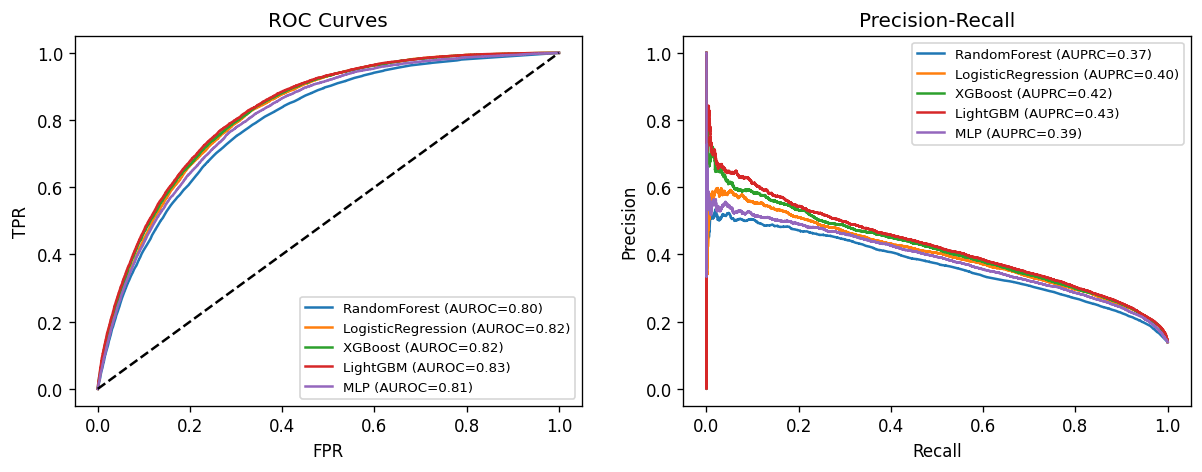

In [ ]:

fig, axes = plt.subplots(1,2, figsize=(12,4))
for name, y_proba in baseline_probas.items():
    try:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[0].plot(fpr, tpr, label=f"{name} (AUROC={baseline_metrics.loc[name,'AUROC']:.2f})")
    except Exception:
        pass
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        axes[1].plot(recall, precision, label=f"{name} (AUPRC={pr_auc:.2f})")
    except Exception:
        pass
axes[0].plot([0,1],[0,1],"k--")
axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].set_title("ROC Curves")
axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].set_title("Precision-Recall")
axes[0].legend(fontsize=8); axes[1].legend(fontsize=8)
plt.show()

       feature  importance  cum_importance
0          BMI    0.173891        0.173891
1          Age    0.117371        0.291262
2     PhysHlth    0.075520        0.366782
3     MentHlth    0.056793        0.423575
4     HighBP_0    0.025152        0.448727
5     HighBP_1    0.023161        0.471888
6  Education_5    0.019858        0.491747
7  Education_4    0.019769        0.511516
8     Fruits_0    0.018597        0.530113
9     Fruits_1    0.018508        0.548621


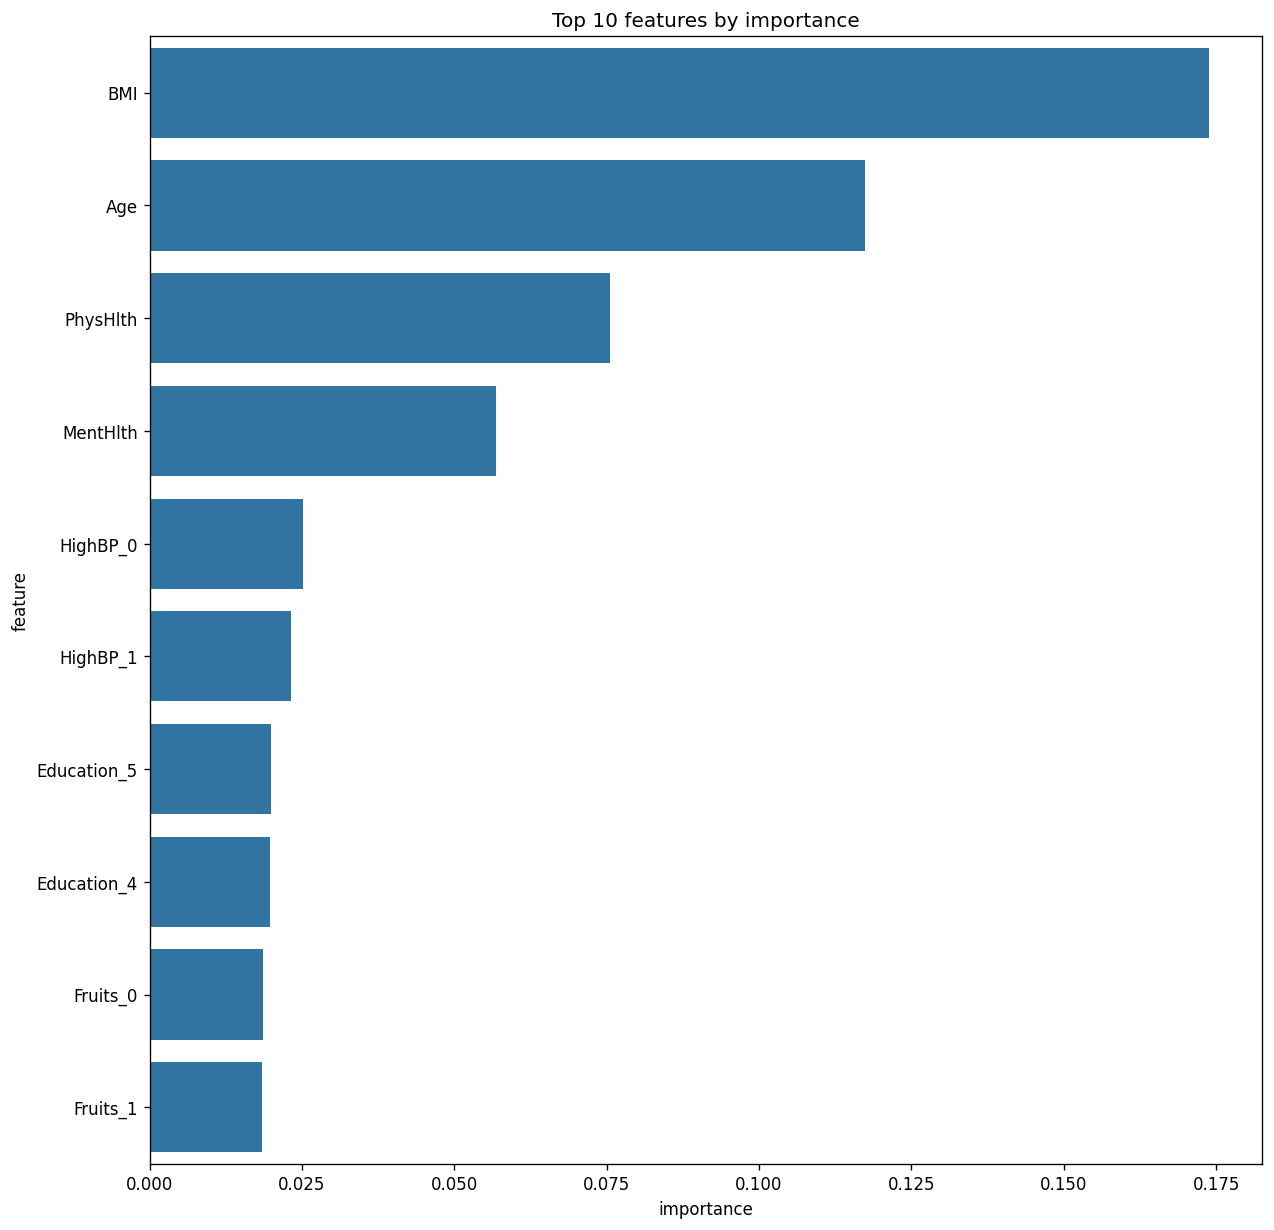

In [ ]:
fi_show = fi_df.copy()
print(fi_show.head(10))
# bar plot
# plt.figure(figsize=(8,8))
# plt.subplot(1, 2, 1)
plt.rcParams['figure.dpi'] = 120  # or higher = smaller appearance
fig, ax = plt.subplots(figsize=(10,10))
plt.tight_layout()
sns.barplot(data=fi_show.head(10), x="importance", y="feature", ax=ax)
ax.set_title("Top 10 features by importance")
plt.show()

In [ ]:
threshold = fi_threshold
selected = fi_df[fi_df["importance"] > threshold]["feature"].tolist()
print(f"Selected features above threshold ({threshold}): {len(selected)} features")
# map selected features back to indices in transformed array
selected_indices = [i for i, f in enumerate(feature_names) if f in selected]
selected_indices = selected_indices

# if len(selected_indices) == 0:
#     st.warning("No features selected with this threshold. Lower the threshold.")
# else:
#     # retrain reduced models (on transformed arrays)
#     with st.spinner("Retraining models on reduced feature set..."):
reduced_trained, reduced_metrics = retrain_on_selected(X_train_trans, X_test_trans, selected_indices, y_train, y_test, base_models)
reduced_trained = reduced_trained
reduced_metrics = reduced_metrics
    # st.success("Retrained on reduced feature set.")

# # Show reduced metrics if available
# if reduced_metrics is not None:
#     print("### Reduced-feature model performance")
print(reduced_metrics.round(4))

Selected features above threshold (0.02): 6 features
[LightGBM] [Info] Number of positive: 24742, number of negative: 152834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 177576, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139332 -> initscore=-1.820850
[LightGBM] [Info] Start training from score -1.820850
                    Precision  Recall      F1   AUROC   AUPRC
RandomForest           0.3814  0.1281  0.1917  0.7347  0.2946
LogisticRegression     0.4639  0.0661  0.1157  0.7797  0.3389
XGBoost                0.4991  0.0783  0.1353  0.7827  0.3522
LightGBM               0.5199  0.0739  0.1295  0.7863  0.3598
MLP                    0.5395  0.0715  0.1262  0.7871  0.3616


### **Step 6: Digital Twin Simulation and Patient Simlarity**

- Computes similarity between a chosen test patient and the rest of the test set, under different metrics, to identify similar patients for twin analysis.

- Currently built on

- euclidean: distances → similarity = (1 - dist/max) * 100
- cosine: cosine similarities normalized to 0..100
- manhattan: similar to euclidean

- Masks the query patient (set to -inf or remove)

- Returns top_k indices and their similarity scores

### Similar-patient insights & digital twin simulation
Selected test-set patient index: 0 (0..76103)
Top similar patient indices (test-set indices) and similarity %:
   test_idx  similarity_pct
0     44343          98.614
1     34317          92.886
2     61407          92.883
3     21075          92.880
4     59910          92.879
Baseline predicted probabilities (selected patient):
{'RandomForest': 0.005, 'LogisticRegression': 0.02175375674457743, 'XGBoost': 0.01153579168021679, 'LightGBM': 0.013186161936809559, 'MLP': 0.004292254123818393}
Predicted probabilities for similar patients (before -> after intervention):
   test_idx  similarity_pct  RandomForest_before  RandomForest_after  \
0     44343          98.614               0.1050               0.235   
1     34317          92.886               0.0017               0.000   
2     61407          92.883               0.0000               0.005   
3     21075          92.880               0.0050               0.620   
4     59910   

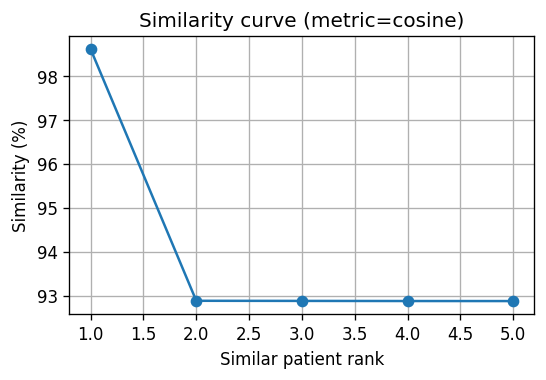

In [ ]:
print("### Similar-patient insights & digital twin simulation")
if trained_pipelines is None:
    print("Train models first")
else:
    # ensure patient_idx valid
    max_idx = X_test.shape[0]-1
    patient_idx = min(max(0, int(patient_idx)), max_idx)
    print(f"Selected test-set patient index: {patient_idx} (0..{max_idx})")

    # choose which trained pipelines to use for predictions
    trained = trained_pipelines
    # similarity space
    X_sim_space = X_test_mm  # min-max scaled transformed test set

    if run_similarity:
        # compute top-k similar
        top_idx, top_sims = get_similar_indices(X_sim_space, patient_idx, metric=sim_metric, top_k=top_k)
        print("Top similar patient indices (test-set indices) and similarity %:")
        sim_df = pd.DataFrame({"test_idx": top_idx, "similarity_pct": np.round(top_sims,3)})
        print(sim_df)

        # baseline probs for selected patient
        patient_row = X_test.iloc[[patient_idx]]
        baseline_probs = {}
        for name, pipe in trained.items():
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                baseline_probs[name] = float(pipe.predict_proba(patient_row)[0,1])
            else:
                baseline_probs[name] = float(pipe.predict(patient_row)[0])
        print("Baseline predicted probabilities (selected patient):")
        print(baseline_probs)

        # for each similar patient, compute prob before/after intervention for each model
        rows = []
        for idx, sim_pct in zip(top_idx, top_sims):
            sim_row = X_test.iloc[[idx]]
            info = {"test_idx": int(idx), "similarity_pct": float(np.round(sim_pct,3))}
            for name, pipe in trained.items():
                if hasattr(pipe.named_steps['clf'], "predict_proba"):
                    prob_before = float(pipe.predict_proba(sim_row)[0,1])
                else:
                    prob_before = float(pipe.predict(sim_row)[0])
                sim_after_row = apply_intervention(sim_row.iloc[0], bmi_delta=bmi_delta, set_phys_active=set_phys_active).to_frame().T
                if hasattr(pipe.named_steps['clf'], "predict_proba"):
                    prob_after = float(pipe.predict_proba(sim_after_row)[0,1])
                else:
                    prob_after = float(pipe.predict(sim_after_row)[0])
                info[f"{name}_before"] = round(prob_before,4)
                info[f"{name}_after"] = round(prob_after,4)
                info[f"{name}_delta"] = round(prob_before - prob_after,4)
            rows.append(info)
        result_df = pd.DataFrame(rows)
        print("Predicted probabilities for similar patients (before -> after intervention):")
        print(result_df)

        # average improvement per model
        avg_imp = {}
        for name in trained.keys():
            avg_imp[name] = float(result_df[f"{name}_delta"].mean())
        print("Average risk reduction across top-K similar patients (prob_before - prob_after):")
        print(avg_imp)

        # plot similarity curve (top PLOT_TOP_N)
        plot_n = min(len(top_sims),  min(10, PLOT_TOP_N))
        fig, ax = plt.subplots(figsize=(5,3))
        ax.plot(np.arange(1, len(top_sims)+1), top_sims, marker='o')
        ax.set_xlabel("Similar patient rank")
        ax.set_ylabel("Similarity (%)")
        ax.set_title(f"Similarity curve (metric={sim_metric})")
        ax.grid(True)
        plt.show()

    else:
        print("Click 'Run similarity insights' in the sidebar to compute similar patients and interventions.")


# Future Directions

## For the Notebook and Streamlit app
    - Complete documentation and optimize it for deploying on web
    - COmplete the conceptual pieces for methods - currently only defined in a easy-to-understand way

## For the model and Digital Twin framework
    - Implement the workflow on a bigger dataset, design temporal associations as well between patients- concept of "real twin" by computing similarity
    - Hoping this can help with zero knowledge validation of twin similarity across the system and help design treatment approach

- Possibly expand it to outpatient measures as well, especially subjective measures- Find the twin of a patient with a self report pain of 5 and try to gauge and quantify the pain level objectively

# What would be needed

- A structured data model with patient's trajectory mapped uniformly across systems - almost like a genetic sequence

- Hopefully, like disease genes have uniform identification and location, EHR can be transformed to the same level- physicians can just look up case with similar sequence for a part of patient's EHR and then inform treatments based on othet patient patterns